In [ ]:
# Import all useful packages into our working enviroment
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import interpolate
from IPython.display import Image

In this notebook, we are going to perform seamless cloning again using a different and faster approach, which is based on mean value coordinate (MVC). The core concept is similar to that in Poisson Image Cloning: we adjust the color within the region of interest (ROI) of the source image according to the relative position between boundary points and ROI pixels as well as the difference between source and target at the boundary.

Let's first introduce the concept of MVC.

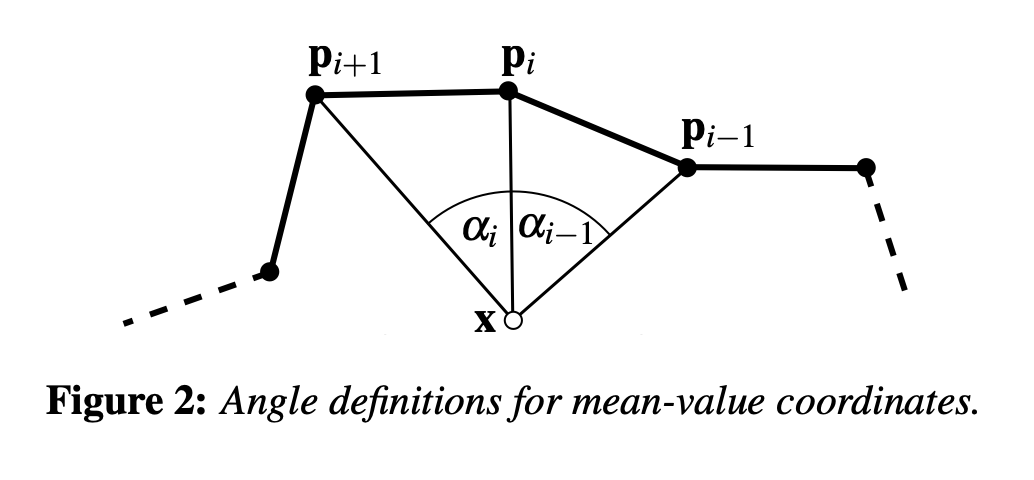

In [2]:
Image(filename='resources/demo2.png') 

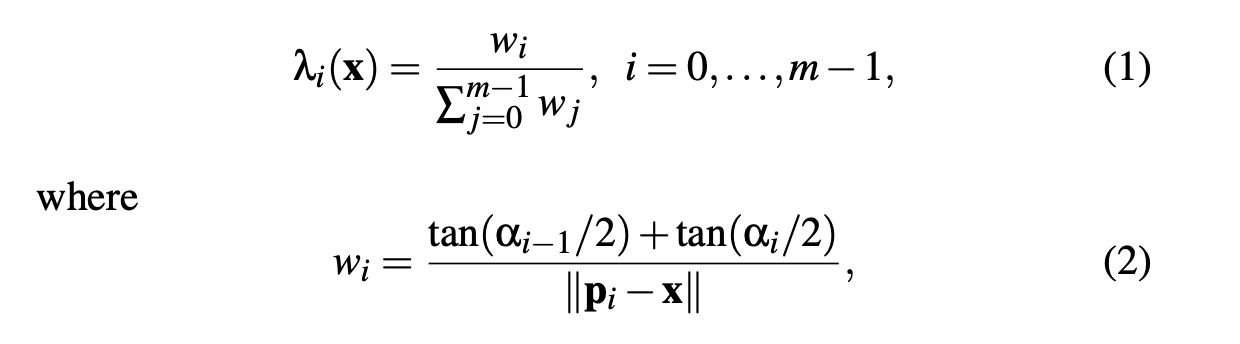

In [3]:
Image(filename='resources/demo3.png') 

We say there are n points within our ROI, and there are m points at the boundary. 

The lambda above constitutes the MVC matrix that we will be using in our cloning process. The x represents all the pixels inside our ROI. So each pixel x has m lambdas, and there are n xs. Piling all lambdas together, we will get a n*m matirx, where the ith row is pixel x's m lambdas. 

To calculate lambda, we have to first get all the alpha angles. The problem is that we need all the boundary points to be in order, else the obtained alpha would not make any sense. I tried to order the boundary pixels by selecting the next pixel whose Euclidean distance is the smallest from the current, but I noticed that the there might be noisy points around the boundary of the mask, which makes the ROI polygon extremely irregular. As a result, I chose to manually select our ROI by clicking vertices in order.

Let's now first import all pictures. This time we do not need the mask anymore as we will select the ROI ourselves. 

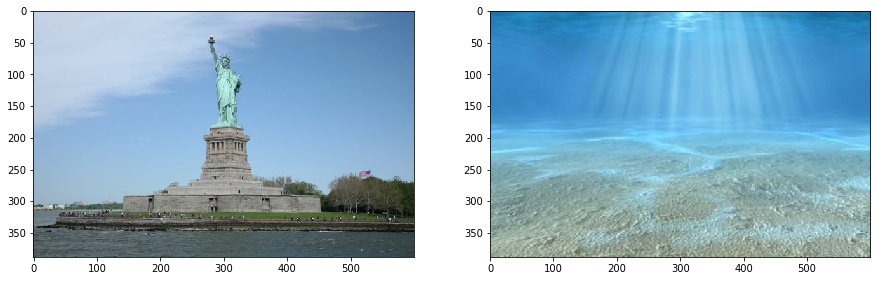

In [4]:
# Import the desired source and targe into our working enviroment
# 
raw_source = cv2.imread('resources/2source.jpg',cv2.IMREAD_COLOR) 
raw_target = cv2.imread('resources/2target.jpg',cv2.IMREAD_COLOR) 

source_shape = raw_source.shape[:-1]
target_shape = raw_target.shape[:-1]

# Limit the range of our concern to pictures with the same shape
assert(source_shape == target_shape)

# Show the two pictures that we will be performing MVC instant image cloning on
x, y = plt.subplots(1,2,figsize=(15,25))
y[0].imshow(raw_source[:,:,::-1])
y[1].imshow(raw_target[:,:,::-1])

In [5]:
# Now manually select the boundary of the object, save all chosen vertices within a list named "selected_boundary"
selected_boundary = []
def on_EVENT_LBUTTONDOWN(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        selected_boundary.append([y, x])
        cv2.circle(raw_source, (x, y), 1, (255, 0, 0), thickness=-1)
        cv2.imshow("image", raw_source)

cv2.namedWindow("image")
cv2.setMouseCallback("image", on_EVENT_LBUTTONDOWN)
cv2.imshow("image", raw_source)

cv2.waitKey(0)
selected_boundary = np.array(selected_boundary)

In [6]:
def calculate_internal_boundary(selected_points, kind="slinear"):
    """
    interpolate all internal points
    """
    new_boundary = []
    for i in range(selected_points.shape[0]-1):
        x1, y1 = selected_points[i]
        x2, y2 = selected_points[i + 1]
        
        if abs(x1 - x2) < abs(y1 - y2):
            #Fit a function for those points
            f = interpolate.interp1d([y1, y2], [x1, x2], kind=kind)
            y_ls = np.linspace(y1, y2, abs(y1 - y2), False).astype(int)
            x_interp = f(y_ls)
            new_boundary += [[x_interp[i], y_ls[i]] for i in range(abs(y1 - y2))]
        
        else:
            f = interpolate.interp1d([x1, x2], [y1, y2], kind=kind)
            x_ls = np.linspace(x1, x2, abs(x1 - x2), False).astype(int)
            y_interp = f(x_ls)
            new_boundary += [[x_ls[i], y_interp[i]] for i in range(abs(x1 - x2))]
            
    return np.round(np.array(new_boundary), 1).astype(int)

In [7]:
new_boundary = calculate_internal_boundary(selected_boundary)

In [8]:
def draw_line(lines):
    """
    draw all lines by connectinga all the selected vertices
    """
    for i in range(lines.shape[0]-1):
        cv2.line(raw_source, tuple(lines[i][::-1]), tuple(lines[i + 1][::-1]), color=(0, 0, 0), thickness=1)
    for i in range(selected_boundary.shape[0]-1):
        cv2.circle(raw_source, tuple(selected_boundary[i][::-1]), 1, (0, 255, 0), thickness=-1)
    cv2.imshow("image", raw_source)
    cv2.waitKey(0)

In [9]:
draw_line(new_boundary)

In [10]:
#get all internal points using cv2.pointPolygonTest function
#pointPolygonTest returns positive number if the point is within the boundary, vice versa\
internal_pts = np.array([[i, j] 
                         for i in range(raw_source.shape[0]) 
                         for j in range(raw_source.shape[1]) 
                         if cv2.pointPolygonTest(new_boundary, (i, j), False) > 0]).astype(int)

In [11]:
def draw_internal():
    """
    check internal points
    """
    raw_source = cv2.imread('resources/2source.jpg',cv2.IMREAD_COLOR) 
    src = raw_source.copy()
    for i in range(selected_boundary.shape[0]-1):
        cv2.line(raw_source, tuple(selected_boundary[i][::-1]), tuple(selected_boundary[i + 1][::-1]), color=(0, 0, 0), thickness=1)
    for i in range(-selected_boundary.shape[0]-1):
        cv2.circle(raw_source, tuple(selected_boundary[i][::-1]), 1, (0, 255, 0), thickness=-1)
    for point in internal_pts:
        cv2.circle(raw_source, tuple(point[::-1]), 1, (0, 0, 0), thickness=0)
    together = cv2.addWeighted(raw_source, 0.3, src, 0.7, 0)
    cv2.imshow("image", together)
    cv2.waitKey(0)

In [12]:
draw_internal()

In [13]:
#Get the difference at the boundary
raw_source = cv2.imread('resources/2source.jpg',cv2.IMREAD_COLOR) / 255 
raw_target = cv2.imread('resources/2target.jpg',cv2.IMREAD_COLOR) / 255
diff = (raw_target - raw_source)[new_boundary[:, 0], new_boundary[:, 1]]

Now perform the following algorithms and speeds it up by using matrix operation:

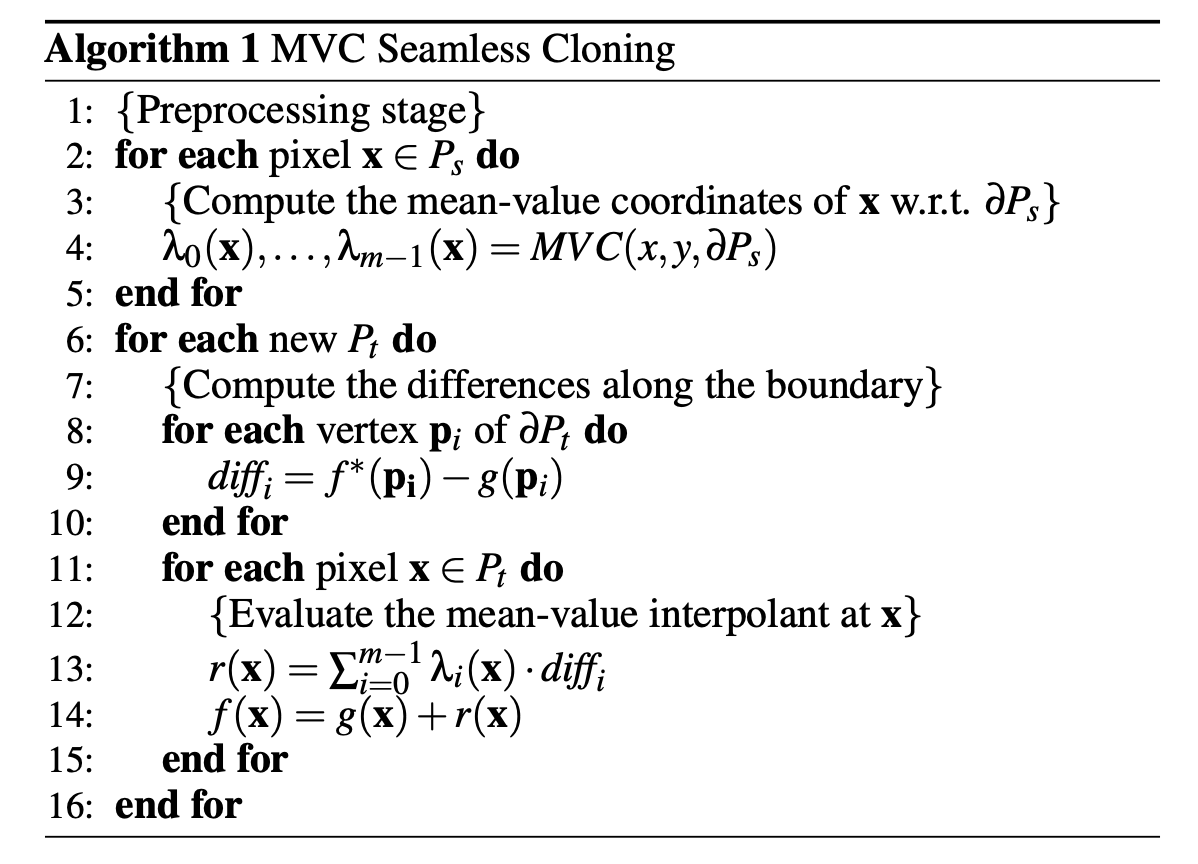

In [14]:
Image(filename='resources/demo4.png') 

In [15]:
MVC = np.zeros((internal_pts.shape[0], new_boundary.shape[0]))
for i, internal_pt in enumerate(internal_pts):
    vector_to_vertex = new_boundary - internal_pt
    dis_to_vertex = np.linalg.norm(vector_to_vertex, axis = 1, keepdims=True)
    vector_to_vertex = vector_to_vertex / dis_to_vertex  # normalized 
    cosine_value = (vector_to_vertex * np.vstack((vector_to_vertex[1:],vector_to_vertex[0]))).sum(1, keepdims=True)
    cosine_value = np.clip(cosine_value, -1 + 1e-10, 1 - 1e-10)
    tan_value = np.sqrt((1 - cosine_value) / (1 + cosine_value))
    weights = (tan_value + np.vstack((tan_value[-1], tan_value[:-1]))) / dis_to_vertex
    MVC[i] = np.squeeze(weights / weights.sum())

In [16]:
diff_internal = MVC.dot(diff)

In [17]:
raw_target[internal_pts[:, 0], internal_pts[:, 1]] = diff_internal + raw_source[internal_pts[:, 0], internal_pts[:, 1]]

In [18]:
cv2.imshow('img', raw_target)
cv2.waitKey(0)

0